In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
import emoji

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report
# from wordcloud import WordCloud ,STOPWORDS
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import sent_tokenize, word_tokenize
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
data = pd.read_csv('./emotion/reddit_25000p.csv')
data

created_utc                                          full_link  \
0       1638681741  https://www.reddit.com/r/Anxiety/comments/r98f...   
1       1613957520  https://www.reddit.com/r/Anxiety/comments/lpbv...   
2       1594409834  https://www.reddit.com/r/love/comments/hovlma/...   
3       1604436889  https://www.reddit.com/r/happy/comments/jnimes...   
4       1631303924  https://www.reddit.com/r/happy/comments/plsg4s...   
...            ...                                                ...   
19995   1589480261  https://www.reddit.com/r/Anger/comments/gjrsqx...   
19996   1579070627  https://www.reddit.com/r/sad/comments/eoysqf/a...   
19997   1587496222  https://www.reddit.com/r/sad/comments/g5lhnp/t...   
19998   1627794357  https://www.reddit.com/r/love/comments/ovm5ka/...   
19999   1592550347  https://www.reddit.com/r/love/comments/hbw1ya/...   

       num_comments  score                                           selftext  \
0                 7      1  * Please no anti-vax conspiracy comments pleas...   
1                 5      1  It’s not a headache but close to it, like an a...   
2                 0      1  I truely love you. I had a sweet dream about y...   
3                31      1                                                NaN   
4                 0      1                                                NaN   
...             ...    ...                                                ...   
19995             1      1  Growing up we had a relatively stable relation...   
19996             0      1                                                NaN   
19997             0      2  **The homeless guy living under the bridge vib...   
19998             7      1  So I’m going to try and keep this short and sw...   
19999             4      1  It's become painfully obvious that you'll neve...   

                                                   title    label  
0                                Just got COVID booster!  anxiety  
1      Sometimes I think so much my head feels physic...  anxiety  
2                                                 Austin     love  
3      The Difference 6 months makes.. A few hiccups ...    happy  
4      Finally got approval from my doctor to get the...    happy  
...                                                  ...      ...  
19995  My brother is always angry or on the verge of ...    anger  
19996  A sad song playlist for melancholic days 🌒🌒 hi...      sad  
19997      The homeless guy living under the bridge vibe      sad  
19998                      Scared of not finding someone     love  
19999                                     I hate myself.     love  

[20000 rows x 7 columns]

In [3]:
print("Number or Duplicate values : ", data.duplicated().sum())
data = data.drop(data[data.duplicated() == True].index, axis = 0).reset_index(drop = True)
print("Number or Duplicate values : ", data.duplicated().sum())

Number or Duplicate values :  0
Number or Duplicate values :  0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   created_utc   20000 non-null  int64 
 1   full_link     20000 non-null  object
 2   num_comments  20000 non-null  int64 
 3   score         20000 non-null  int64 
 4   selftext      15796 non-null  object
 5   title         20000 non-null  object
 6   label         20000 non-null  object
dtypes: int64(3), object(4)
memory usage: 1.1+ MB


In [5]:
data['label'].value_counts()

anxiety    4000
love       4000
happy      4000
anger      4000
sad        4000
Name: label, dtype: int64

## Preprocessing

In [6]:
contractions_dict = { 
"ain't": "am not / are not / is not / has not / have not","aren't": "are not / am not","can't": "cannot","can't've": "cannot have","'cause": "because",
    "could've": "could have","couldn't": "could not","couldn't've": "could not have","didn't": "did not","doesn't": "does not","don't": "do not",
    "hadn't": "had not","hadn't've": "had not have","hasn't": "has not","haven't": "have not","he'd": "he had / he would","he'd've": "he would have",
    "he'll": "he shall / he will","he'll've": "he shall have / he will have","he's": "he has / he is","how'd": "how did","how'd'y": "how do you",
    "how'll": "how will","how's": "how has / how is / how does","I'd": "I had / I would","I'd've": "I would have","I'll": "I shall / I will",
    "I'll've": "I shall have / I will have","I'm": "I am","I've": "I have","isn't": "is not","it'd": "it had / it would","it'd've": "it would have",
    "it'll": "it shall / it will","it'll've": "it shall have / it will have","it's": "it has / it is","let's": "let us","ma'am": "madam","mayn't": "may not",
    "might've": "might have","mightn't": "might not","mightn't've": "might not have","must've": "must have","mustn't": "must not","mustn't've": "must not have",
    "needn't": "need not","needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not","oughtn't've": "ought not have","shan't": "shall not",
    "sha'n't": "shall not","shan't've": "shall not have","she'd": "she had / she would","she'd've": "she would have","she'll": "she shall / she will",
    "she'll've": "she shall have / she will have","she's": "she has / she is","should've": "should have","shouldn't": "should not",
    "shouldn't've": "should not have","so've": "so have","so's": "so as / so is","that'd": "that would / that had","that'd've": "that would have",
    "that's": "that has / that is","there'd": "there had / there would","there'd've": "there would have","there's": "there has / there is",
    "they'd": "they had / they would","they'd've": "they would have","they'll": "they shall / they will","they'll've": "they shall have / they will have",
    "they're": "they are","they've": "they have","to've": "to have","wasn't": "was not","we'd": "we had / we would","we'd've": "we would have",
    "we'll": "we will","we'll've": "we will have","we're": "we are","we've": "we have","weren't": "were not","what'll": "what shall / what will",
    "what'll've": "what shall have / what will have","what're": "what are","what's": "what has / what is","what've": "what have","when's": "when has / when is",
    "when've": "when have","where'd": "where did","where's": "where has / where is","where've": "where have","who'll": "who shall / who will",
    "who'll've": "who shall have / who will have","who's": "who has / who is","who've": "who have","why's": "why has / why is","why've": "why have",
    "will've": "will have","won't": "will not","won't've": "will not have","would've": "would have","wouldn't": "would not","wouldn't've": "would not have",
    "y'all": "you all","y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
    "you'd": "you had / you would","you'd've": "you would have","you'll": "you shall / you will","you'll've": "you shall have / you will have",
    "you're": "you are","you've": "you have"
}


In [7]:
def preprocess_inputs(df):
    df = df.copy()
    
    ## filling missing values 
    df['title'] = df['title'].str.lower()
    df['selftext'] = df['selftext'].str.lower()
    
    df['selftext'] = df['selftext'].fillna('',axis = 0)
    df['title'] = df['title'].fillna('',axis = 0)
    
    ## preprocessing emoji
    df['title'] = df['title'].apply(lambda x: emoji.demojize(x))
    df['selftext'] = df['selftext'].apply(lambda x: emoji.demojize(x))
    
    ## preprocessing of text
    df['title'] = df['title'].str.replace(r'(https:\/\/[\.\-\w\/]+)', '')
    df['selftext'] = df['selftext'].str.replace(r'(https:\/\/[\.\-\w\/]+)', '')
    
    df['selftext'] = df['selftext'].str.replace(r'(\[deleted\])', '')
    df['selftext'] = df['selftext'].str.replace(r'(\[removed\])', '')
    
    
    ## normalising text
    def normalized_func(x):
        temp = x.split(" ")
        for i,t in enumerate(temp):
            if t in contractions_dict.keys():
                temp[i] = contractions_dict[t]
        temp = " ".join(temp)
        return temp
    
    df['title_token'] = df['title'].apply(normalized_func)
    df['selftext_token'] = df['selftext'].apply(normalized_func)
    
    ## tokenizing text 
    df['title_token'] = df['title_token'].apply(lambda x: word_tokenize(x))
    df['selftext_token'] = df['selftext_token'].apply(lambda x: word_tokenize(x))
    
    df['comb_token'] = df['title_token'] + df['selftext_token']
    stop_words = set(stopwords.words('english'))    
    f = lambda x: [item for item in x if item not in stop_words]
    df['comb_token'] = df['comb_token'].apply(f)
    
    def check_punc(word):
        if re.match(r'([A-Za-z\*]+)',word):
            return True
        else:
            return False
    
    df['comb_token'] = df['comb_token'].apply(lambda x:list(filter(check_punc,x)))
    ps = PorterStemmer()
    f = lambda arr: [ps.stem(word) for word in arr]
    df['stem'] = df['comb_token'].apply(f)
    df['final']  = df['stem'].apply(lambda arr: " ".join(arr))
    
    return df

In [8]:
X = preprocess_inputs(data)

C:\Users\user\AppData\Local\Temp\ipykernel_48520\1929106948.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  df['title'] = df['title'].str.replace(r'(https:\/\/[\.\-\w\/]+)', '')
C:\Users\user\AppData\Local\Temp\ipykernel_48520\1929106948.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  df['selftext'] = df['selftext'].str.replace(r'(https:\/\/[\.\-\w\/]+)', '')
C:\Users\user\AppData\Local\Temp\ipykernel_48520\1929106948.py:19: FutureWarning: The default value of regex will change from True to False in a future version.
  df['selftext'] = df['selftext'].str.replace(r'(\[deleted\])', '')
C:\Users\user\AppData\Local\Temp\ipykernel_48520\1929106948.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
  df['selftext'] = df['selftext'].str.replace(r'(\[removed\])', '')


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X['final'], 
                                                    X['label'], 
                                                    test_size=0.2, 
                                                    random_state=42)

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=(1,1),
                        stop_words=None,
                        lowercase=False,
                        max_features=9000,
                        norm='l2',
                        sublinear_tf=True)


features_train = pd.DataFrame(tfidf.fit_transform(X_train).toarray())
labels_train = y_train

features_test = pd.DataFrame(tfidf.transform(X_test).toarray())

labels_test = y_test

## Model Training and Evaluation

In [11]:
from sklearn.linear_model import SGDClassifier
sgd  = SGDClassifier()
sgd.fit(features_train, labels_train)
model_predictions = sgd.predict(features_test)
print('Accuracy: ', accuracy_score(labels_test, model_predictions))
print(classification_report(labels_test, model_predictions))

Accuracy:  0.802
              precision    recall  f1-score   support

       anger       0.91      0.89      0.90       795
     anxiety       0.89      0.87      0.88       804
       happy       0.71      0.84      0.77       814
        love       0.79      0.80      0.79       790
         sad       0.73      0.61      0.66       797

    accuracy                           0.80      4000
   macro avg       0.80      0.80      0.80      4000
weighted avg       0.80      0.80      0.80      4000



In [12]:
from sklearn.ensemble import ExtraTreesClassifier
exclf  = ExtraTreesClassifier(n_estimators=80,n_jobs = -1)
exclf.fit(features_train, labels_train)
model_predictions = exclf.predict(features_test)
print('Accuracy: ', accuracy_score(labels_test, model_predictions))
print(classification_report(labels_test, model_predictions))

Accuracy:  0.776
              precision    recall  f1-score   support

       anger       0.86      0.88      0.87       795
     anxiety       0.84      0.88      0.86       804
       happy       0.77      0.77      0.77       814
        love       0.72      0.78      0.75       790
         sad       0.68      0.57      0.62       797

    accuracy                           0.78      4000
   macro avg       0.77      0.78      0.77      4000
weighted avg       0.77      0.78      0.77      4000



In [13]:
from sklearn.ensemble import RandomForestClassifier
model_rand  = RandomForestClassifier(n_estimators=80,n_jobs = -1)
model_rand.fit(features_train, labels_train)
model_predictions = model_rand.predict(features_test)
print('Accuracy: ', accuracy_score(labels_test, model_predictions))
print(classification_report(labels_test, model_predictions))

Accuracy:  0.762
              precision    recall  f1-score   support

       anger       0.86      0.86      0.86       795
     anxiety       0.86      0.86      0.86       804
       happy       0.75      0.75      0.75       814
        love       0.71      0.77      0.74       790
         sad       0.63      0.57      0.60       797

    accuracy                           0.76      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.76      0.76      0.76      4000



In [15]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(features_train, labels_train)
mnb_predictions = mnb.predict(features_test)
print('Accuracy: ', accuracy_score(labels_test, mnb_predictions))
print(classification_report(labels_test, mnb_predictions))

Accuracy:  0.7495
              precision    recall  f1-score   support

       anger       0.79      0.90      0.84       795
     anxiety       0.79      0.85      0.82       804
       happy       0.83      0.64      0.73       814
        love       0.66      0.84      0.74       790
         sad       0.70      0.51      0.59       797

    accuracy                           0.75      4000
   macro avg       0.75      0.75      0.74      4000
weighted avg       0.75      0.75      0.74      4000



In [16]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
labels_train = lb.fit_transform(labels_train)
labels_test =lb.transform(labels_test)


inputs = tf.keras.Input(shape=(features_train.shape[1],))
dense_1 = tf.keras.layers.Dense(128, activation='relu')(inputs)
dense_2 = tf.keras.layers.Dense(128, activation='relu')(dense_1)
outputs = tf.keras.layers.Dense(6, activation='softmax')(dense_2)


model = tf.keras.Model(inputs, outputs)

print(model.summary())
tf.keras.utils.plot_model(model)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    features_train,
    labels_train,
    validation_split=0.2,
    batch_size=32,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
        )
    ]
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9000)]            0         
                                                                 
 dense (Dense)               (None, 128)               1152128   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
Total params: 1,169,414
Trainable params: 1,169,414
Non-trainable params: 0
_________________________________________________________________
None
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/20
400/4

In [17]:
ann_predictions = model.predict([features_test])
ann_predictions = np.argmax(ann_predictions,1)
ann_predictions = lb.inverse_transform(ann_predictions)
labels_test = lb.inverse_transform(labels_test)
labels_train = lb.inverse_transform(labels_train)
print('Accuracy: ', accuracy_score(labels_test, ann_predictions))
print(classification_report(labels_test, ann_predictions))

Accuracy:  0.76725
              precision    recall  f1-score   support

       anger       0.89      0.84      0.86       795
     anxiety       0.90      0.80      0.85       804
       happy       0.78      0.72      0.75       814
        love       0.73      0.76      0.74       790
         sad       0.59      0.72      0.65       797

    accuracy                           0.77      4000
   macro avg       0.78      0.77      0.77      4000
weighted avg       0.78      0.77      0.77      4000



## Results

In [18]:
output = pd.DataFrame([
    ["I am having a panic attack. Help Me!!!!!!!"],
    ["I'm lonely as always... I hate being injured and unemployed. It's sucks not able to do anything"],
    ["When I look at photos of us , videos of us. My eyes get watery , I cry most of the time."],
    ["Nature is so lovely"],
    ["Youtube doesn’t do shit about the NSFW spam bots but doesn’t allow youtubers to swear. The hypocrisy of this fucking platform."]
                      ],
                      columns = ['title'])
output

title
0         I am having a panic attack. Help Me!!!!!!!
1  I'm lonely as always... I hate being injured a...
2  When I look at photos of us , videos of us. My...
3                                Nature is so lovely
4  Youtube doesn’t do shit about the NSFW spam bo...

In [19]:
output['selftext'] = ''
test = preprocess_inputs(output)
f_test = pd.DataFrame(tfidf.transform(test['final']).toarray())
model_pred = sgd.predict(f_test)
model_pred

C:\Users\user\AppData\Local\Temp\ipykernel_48520\1929106948.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  df['title'] = df['title'].str.replace(r'(https:\/\/[\.\-\w\/]+)', '')
C:\Users\user\AppData\Local\Temp\ipykernel_48520\1929106948.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  df['selftext'] = df['selftext'].str.replace(r'(https:\/\/[\.\-\w\/]+)', '')
C:\Users\user\AppData\Local\Temp\ipykernel_48520\1929106948.py:19: FutureWarning: The default value of regex will change from True to False in a future version.
  df['selftext'] = df['selftext'].str.replace(r'(\[deleted\])', '')
C:\Users\user\AppData\Local\Temp\ipykernel_48520\1929106948.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
  df['selftext'] = df['selftext'].str.replace(r'(\[removed\])', '')


array(['anxiety', 'sad', 'love', 'love', 'anger'], dtype='<U7')

In [ ]:
stop

## Analysis

In [ ]:
def analysis(posts):
    test = preprocess_inputs(posts)
    f_test = pd.DataFrame(tfidf.transform(test['final']).toarray())
    model_pred = sgd.predict(f_test)
    test = pd.concat([test,pd.Series(model_pred)], axis = 1)
    test = test.rename(columns = {0:'label'})
    
    fig = plt.figure(figsize = (25,10))
    for idx,col in enumerate(list(test.label.unique())):
        subset=test[test.label==col]
        text= subset.final.values
        words =" ".join(text)
        ax = fig.add_subplot(2,3,idx+1)
        wordcloud = WordCloud(width=800, height=500,random_state=21, max_font_size=110).generate(words)
        ax.imshow(wordcloud, interpolation="bilinear")
        ax.axis('off')
        plt.title(col)
    
    plt.figure(figsize = (10,5))
    plt.subplot(1,2,1)
    sns.countplot(x = 'label', data = test)
    plt.subplot(1,2,2)
    sns.violinplot(y = 'num_comments', x = 'label', data = test)
    plt.show()

In [ ]:
!pip install -q pmaw

In [ ]:
import datetime as dt
from pmaw import PushshiftAPI
import json

api = PushshiftAPI()

subreddit = "teenagers"

limit = 2000
posts = api.search_submissions(
    subreddit=subreddit, limit=limit, filter=['title','selftext','full_link','num_comments','score'])

posts = list(posts)

arr = [thing for thing in posts]

posts = pd.DataFrame(arr)
posts

created_utc                                          full_link  \
0      1613769167  https://www.reddit.com/r/teenagers/comments/ln...   
1      1613769141  https://www.reddit.com/r/teenagers/comments/ln...   
2      1613769094  https://www.reddit.com/r/teenagers/comments/ln...   
3      1613769016  https://www.reddit.com/r/teenagers/comments/ln...   
4      1613768939  https://www.reddit.com/r/teenagers/comments/ln...   
...           ...                                                ...   
1995   1626380853  https://www.reddit.com/r/teenagers/comments/ol...   
1996   1626380840  https://www.reddit.com/r/teenagers/comments/ol...   
1997   1626380839  https://www.reddit.com/r/teenagers/comments/ol...   
1998   1626380836  https://www.reddit.com/r/teenagers/comments/ol...   
1999   1626380832  https://www.reddit.com/r/teenagers/comments/ol...   

      num_comments  score                                           selftext  \
0                9      1  Idk how to write all this but ill try (sorry f...   
1               59      1  She was NOT a good person and made my mum's li...   
2                7      1  No, no nonononoooo it's a weekend so I could s...   
3                6      1                           Listen to it. Right now.   
4                6      1  The boys, the girls they all like carmen\n\nsh...   
...            ...    ...                                                ...   
1995             6      1                                                      
1996            19      0  No you didn't OP, you have 1000 hours on a foo...   
1997            18      1  Hey redditors. I am 13 and I was just wonderin...   
1998             4      1  It’s been 3 days since I’ve taken them and als...   
1999             6      1  I told him “anything that ends in “-ese” is as...   

                                                  title  
0                                        So em... title  
1               My grandmother tried to electrocute me.  
2          Posting here daily until I get a gf: Day 267  
3                           Tommy's Party by Peach Pit.  
4                                        This is weird.  
...                                                 ...  
1995                          A little revamp from 2014  
1996                           I finally found a gf!?!?  
1997            Is my music taste rare among teenagers?  
1998                 I can’t find my antidepressants :D  
1999  The other day i was explaining to my little br...  

[2000 rows x 6 columns]

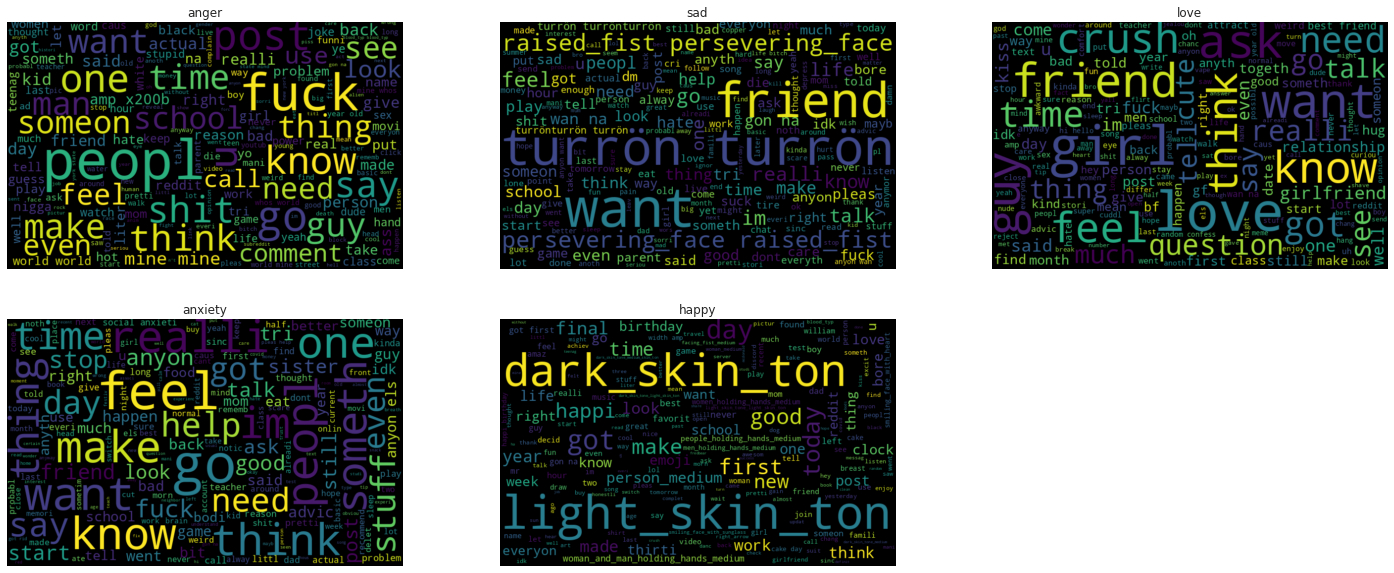

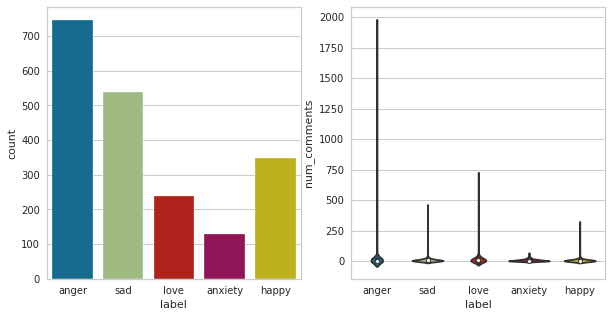

In [ ]:
analysis(posts)

In [ ]:
import datetime as dt
from pmaw import PushshiftAPI
import json

api = PushshiftAPI()

subreddit = "depressed"

limit = 2000
posts = api.search_submissions(
    subreddit=subreddit, limit=limit, filter=['title','selftext','full_link','num_comments','score'])

posts = list(posts)

arr = [thing for thing in posts]

posts = pd.DataFrame(arr)
posts

created_utc                                          full_link  \
0      1616915851  https://www.reddit.com/r/depressed/comments/me...   
1      1616915136  https://www.reddit.com/r/depressed/comments/me...   
2      1616912273  https://www.reddit.com/r/depressed/comments/me...   
3      1616912018  https://www.reddit.com/r/depressed/comments/me...   
4      1616909199  https://www.reddit.com/r/depressed/comments/me...   
...           ...                                                ...   
1995   1622751556  https://www.reddit.com/r/depressed/comments/nr...   
1996   1622750445  https://www.reddit.com/r/depressed/comments/nr...   
1997   1622750215  https://www.reddit.com/r/depressed/comments/nr...   
1998   1622749596  https://www.reddit.com/r/depressed/comments/nr...   
1999   1622745466  https://www.reddit.com/r/depressed/comments/nr...   

      num_comments  score                                           selftext  \
0                2      1  This is just some personal observations and ve...   
1                0      1                                          [removed]   
2                0      1  I just got reddit and idk it feels nice knowin...   
3                0      1                                          [removed]   
4                0      1  I'm 15 years old, and I've lost a lot of frien...   
...            ...    ...                                                ...   
1995             0      1  Hi, it's my first post and the first time i ta...   
1996             3      2  As the title states I am a loser, I've never a...   
1997             0      1  I think I'm depressed. I cry every night becau...   
1998             0      1  at this point, i’m feeling unaffected by every...   
1999             7      1                                          [removed]   

                                                  title  
0                                            Melancholy  
1                                                 tired  
2                               Im fine lol (no im not)  
3            A WARNING TO THE PEOPLE OF THIS SUBREDDIT:  
4     I'm 15 years old, and I don't know if I'm depr...  
...                                                 ...  
1995                               I don't feel so good  
1996                                       I am a Loser  
1997                                      I'm depressed  
1998                                        i feel numb  
1999   For me waking up is already a hard thing to do..  

[2000 rows x 6 columns]

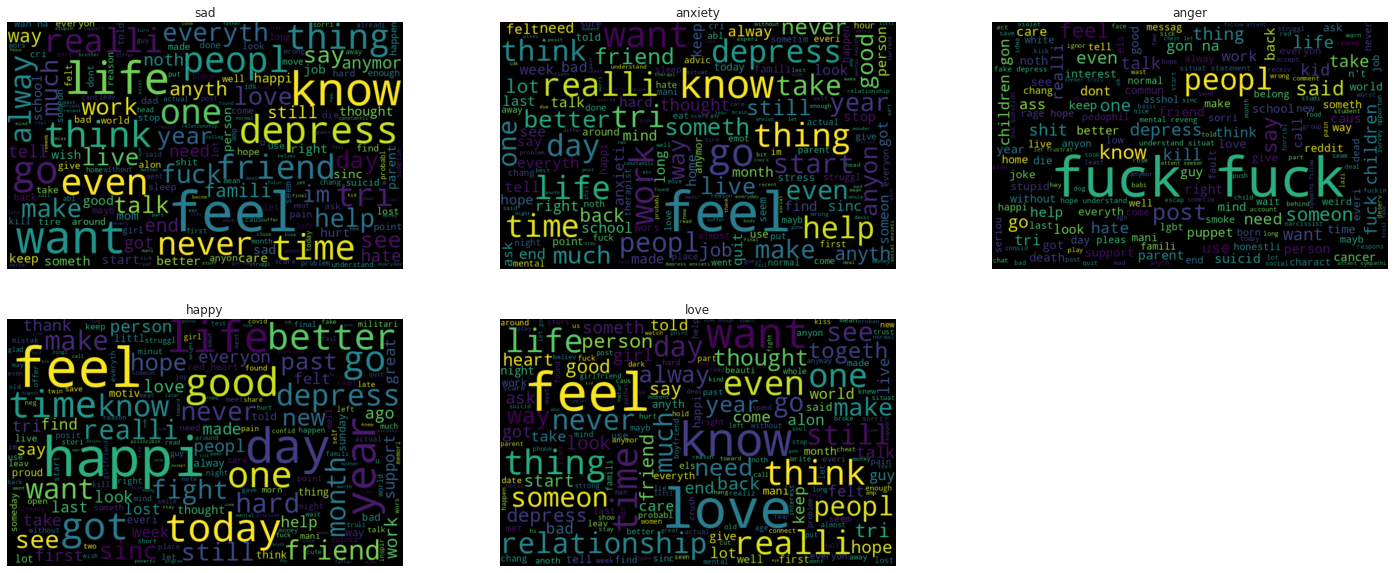

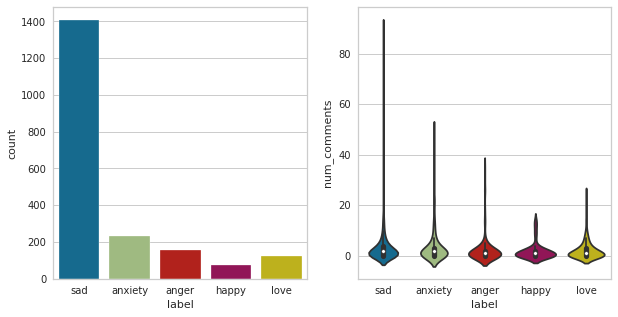

In [ ]:
analysis(posts)

In [ ]:
import datetime as dt
from pmaw import PushshiftAPI
import json

api = PushshiftAPI()

subreddit = "relationships"

limit = 2000
posts = api.search_submissions(
    subreddit=subreddit, limit=limit, filter=['title','selftext','full_link','num_comments','score'])

posts = list(posts)

arr = [thing for thing in posts]

posts = pd.DataFrame(arr)
posts

created_utc                                          full_link  \
0      1623230018  https://www.reddit.com/r/relationships/comment...   
1      1623229663  https://www.reddit.com/r/relationships/comment...   
2      1623229543  https://www.reddit.com/r/relationships/comment...   
3      1623229501  https://www.reddit.com/r/relationships/comment...   
4      1623229418  https://www.reddit.com/r/relationships/comment...   
...           ...                                                ...   
1995   1626355403  https://www.reddit.com/r/relationships/comment...   
1996   1626355352  https://www.reddit.com/r/relationships/comment...   
1997   1626355291  https://www.reddit.com/r/relationships/comment...   
1998   1626355109  https://www.reddit.com/r/relationships/comment...   
1999   1626354861  https://www.reddit.com/r/relationships/comment...   

      num_comments  score                                           selftext  \
0               12      1  Hello Reddit. I don’t know what is wrong or ri...   
1               20      1  So, I'll try to keep this short.\n\nI have bee...   
2                7      1  Hello ! My (26M) boyfriend and I (22F) have be...   
3                2      1                                          [removed]   
4                2      1                                                NaN   
...            ...    ...                                                ...   
1995             2      1                                          [removed]   
1996             2      1                                          [removed]   
1997             4      1  To cut to the chase, we have been together for...   
1998             2      1                                          [removed]   
1999             2      1                                          [removed]   

                                                  title  
0     How to react to boyfriend and his baby mama me...  
1     Help me sort my relationship out (is my boyfri...  
2     How to approach partner about feeling unattrac...  
3     How to react to boyfriend and baby mama meetin...  
4     How to react to boyfriend and baby mama meetin...  
...                                                 ...  
1995  I (F/25) cry way too easily when it comes to m...  
1996  My BF (30) of 6 yrs emotionally cheated on me ...  
1997  I’m (37M) trying to leave my girlfriend (37F) ...  
1998  Everytime a guy comes to me that i like even a...  
1999  Everytime a guy comes to me that i like even a...  

[2000 rows x 6 columns]

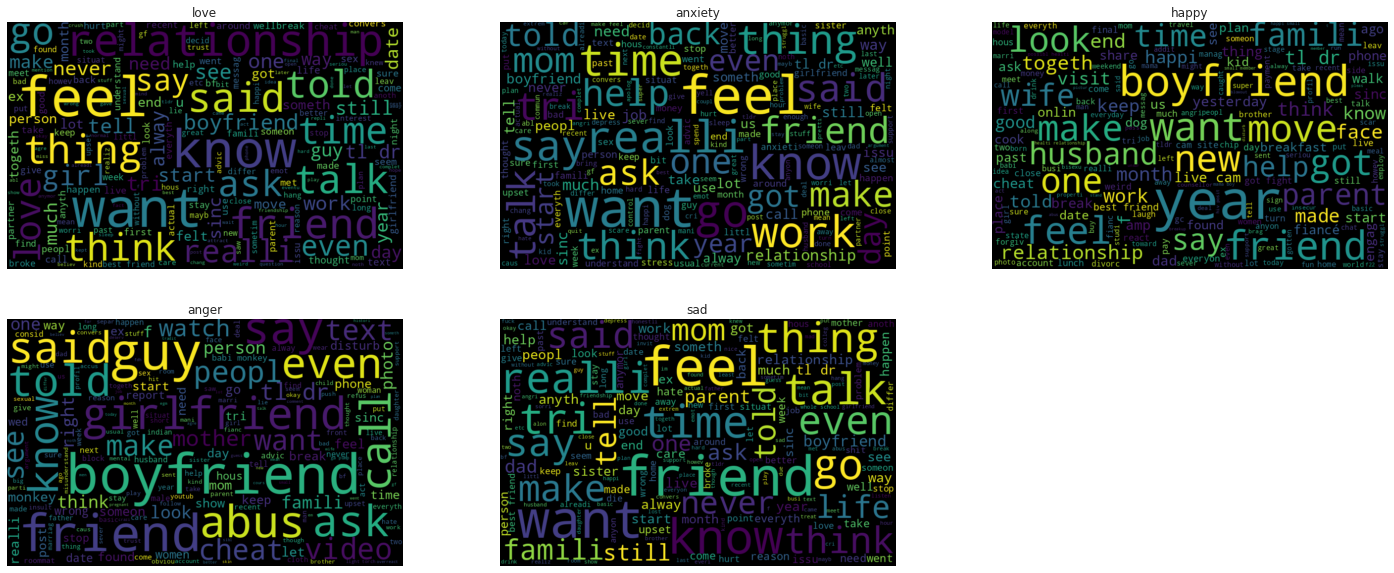

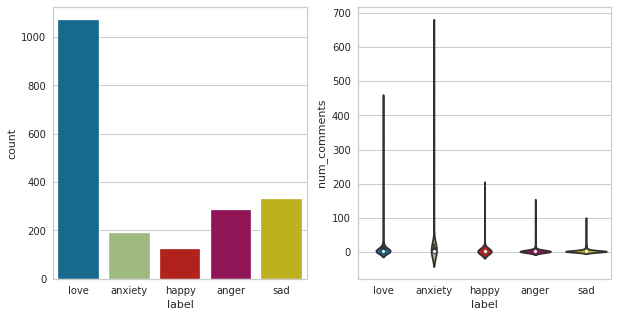

In [ ]:
analysis(posts)

In [ ]:
import datetime as dt
from pmaw import PushshiftAPI
import json

api = PushshiftAPI()

subreddit = "abuse"

limit = 2000
posts = api.search_submissions(
    subreddit=subreddit, limit=limit, filter=['title','selftext','full_link','num_comments','score'])

posts = list(posts)

arr = [thing for thing in posts]

posts = pd.DataFrame(arr)
posts

created_utc                                          full_link  \
0      1619808189  https://www.reddit.com/r/abuse/comments/n20h80...   
1      1619806633  https://www.reddit.com/r/abuse/comments/n1zww6...   
2      1619800245  https://www.reddit.com/r/abuse/comments/n1xluf...   
3      1619798978  https://www.reddit.com/r/abuse/comments/n1x56q...   
4      1619795916  https://www.reddit.com/r/abuse/comments/n1w2b1...   
...           ...                                                ...   
1995   1581322414  https://www.reddit.com/r/abuse/comments/f1nchh...   
1996   1581291176  https://www.reddit.com/r/abuse/comments/f1h90w...   
1997   1581283553  https://www.reddit.com/r/abuse/comments/f1feeh...   
1998   1581276455  https://www.reddit.com/r/abuse/comments/f1dlrk...   
1999   1588536987  https://www.reddit.com/r/abuse/comments/gcxdyh...   

      num_comments  score                                           selftext  \
0                0      1  This is the first post I’ve every made on here...   
1                0      1  I AM NOT ASKING FOR A HAND OUT...I NEED SOME O...   
2                0      1  I don't want to mention all the details but my...   
3                0      1  TW: Abuse\n\nLong story short, I'm so tired of...   
4                0      1  Having to move this somewhere else, as I initi...   
...            ...    ...                                                ...   
1995             6      1  I just need to get this off my chest before I ...   
1996             3      1  When my dad died it left a big hole in our fam...   
1997             0      1  I know my problems aren't as bad as other peop...   
1998             9      1  This happens 20 yes ago I am 27 now .. I have ...   
1999             1      1  TW for religion and of course information abou...   

                                                  title  
0              Long story ⚠️TRIGGER WARNING⚠️ -why dad?  
1                           Can anyone please help me??  
2       Is pressing charges on abusive family worth it?  
3              I just need to express my inner thoughts  
4     Should I give my dad another chance and see hi...  
...                                                 ...  
1995        I might be leaving my abusive home tomorrow  
1996  Mum's bf touched me and did stuff that made me...  
1997                                   I need some help  
1998  I was sexually violated by my cousin and I sti...  
1999    The Concept of Family, Religion, and Fitting In  

[2000 rows x 6 columns]

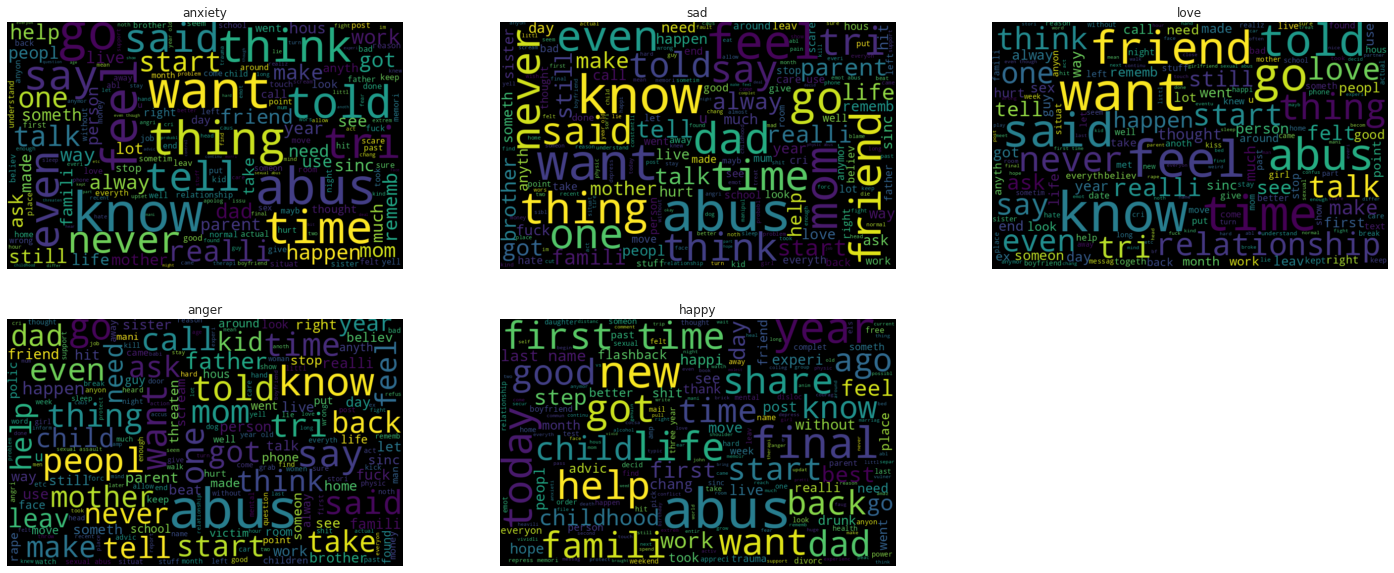

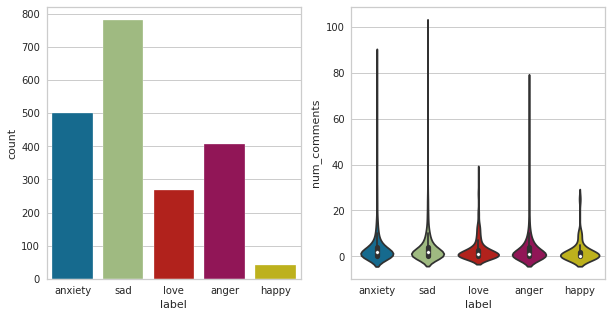

In [ ]:
analysis(posts)

In [ ]:
import datetime as dt
from pmaw import PushshiftAPI
import json

api = PushshiftAPI()

subreddit = "SuicideWatch"

limit = 2000
posts = api.search_submissions(
    subreddit=subreddit, limit=limit, filter=['title','selftext','full_link','num_comments','score'])

posts = list(posts)

arr = [thing for thing in posts]

posts = pd.DataFrame(arr)
posts

created_utc                                          full_link  \
0      1620076728  https://www.reddit.com/r/SuicideWatch/comments...   
1      1620076713  https://www.reddit.com/r/SuicideWatch/comments...   
2      1620076681  https://www.reddit.com/r/SuicideWatch/comments...   
3      1620076652  https://www.reddit.com/r/SuicideWatch/comments...   
4      1620076637  https://www.reddit.com/r/SuicideWatch/comments...   
...           ...                                                ...   
1995   1613730412  https://www.reddit.com/r/SuicideWatch/comments...   
1996   1613730349  https://www.reddit.com/r/SuicideWatch/comments...   
1997   1613729198  https://www.reddit.com/r/SuicideWatch/comments...   
1998   1613729148  https://www.reddit.com/r/SuicideWatch/comments...   
1999   1613728970  https://www.reddit.com/r/SuicideWatch/comments...   

      num_comments  score                                           selftext  \
0                3      1  I finally realized I will certainly die alone ...   
1                2      1  after 3 years of being internally screaming at...   
2                3      1  I just took 20 pills 200mgs each of naproxen s...   
3                0      1  I'm a first time poster. I feel so desperate p...   
4                0      1  I had everything handed to me. I'm transgender...   
...            ...    ...                                                ...   
1995             2      1                                                      
1996             3      1  Any ideas on a painless death?\n\nAsking for a...   
1997             5      1  I'm very sorry if my English is a bit incohere...   
1998             6      1  got diagnosed a few days ago although i don’t ...   
1999             5      1  If you were planning on commuting suicide, wou...   

                                                  title  
0     It is perfectly reasonable for me to end my li...  
1                    i want to die, but im so so scared  
2                                                 Idk..  
3                     It feels like this will never end  
4     I've become a shitty person, a shell and shado...  
...                                                 ...  
1995                      I think Iam going to do it...  
1996                                         Any ideas?  
1997                 Is it my fault for being suicidal?  
1998                                           anorexia  
1999                                  Hypothetically...  

[2000 rows x 6 columns]

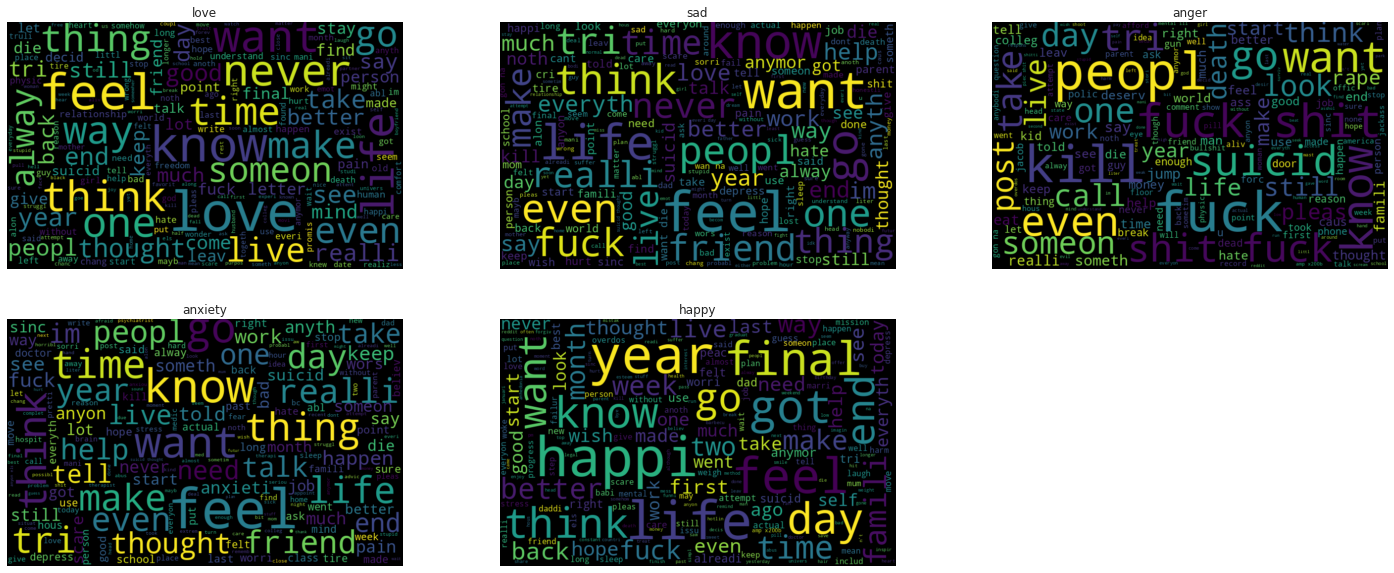

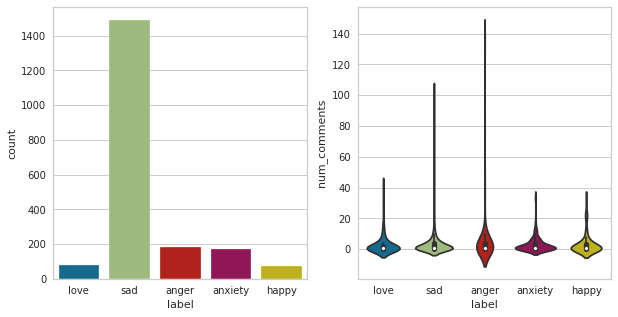

In [ ]:
analysis(posts)

In [ ]:
import datetime as dt
from pmaw import PushshiftAPI
import json

api = PushshiftAPI()

subreddit = "DecidingToBeBetter"

limit = 2000
posts = api.search_submissions(
    subreddit=subreddit, limit=limit, filter=['title','selftext','full_link','num_comments','score'])

posts = list(posts)

arr = [thing for thing in posts]

posts = pd.DataFrame(arr)
posts

created_utc                                          full_link  \
0      1620076631  https://www.reddit.com/r/DecidingToBeBetter/co...   
1      1620076158  https://www.reddit.com/r/DecidingToBeBetter/co...   
2      1620072815  https://www.reddit.com/r/DecidingToBeBetter/co...   
3      1620072477  https://www.reddit.com/r/DecidingToBeBetter/co...   
4      1620071872  https://www.reddit.com/r/DecidingToBeBetter/co...   
...           ...                                                ...   
1995   1626001227  https://www.reddit.com/r/DecidingToBeBetter/co...   
1996   1625999594  https://www.reddit.com/r/DecidingToBeBetter/co...   
1997   1625997472  https://www.reddit.com/r/DecidingToBeBetter/co...   
1998   1625990448  https://www.reddit.com/r/DecidingToBeBetter/co...   
1999   1625989017  https://www.reddit.com/r/DecidingToBeBetter/co...   

      num_comments  score                                           selftext  \
0                1      1                                          [removed]   
1                0      1  I live in a big city, and am surrounded by awe...   
2                5      1  I have addictive tendencies towards Dota 2 and...   
3                0      1   \n I was playing fortnite with a friend and k...   
4                0      1  What to do if I make a decision to follow my s...   
...            ...    ...                                                ...   
1995            21      1  Hey, i'm 25y and always loved to play videogam...   
1996             0      1  "A goal without a plan is just a wish." Antoin...   
1997             0      1                                          [removed]   
1998             0      1                                          [removed]   
1999             0      1                                          [removed]   

                                                  title  
0     How can I build self esteem if i'm too mentall...  
1     I am gamifying eating through my pantry instea...  
2     What are ways that I can make it REALLY hard f...  
3            Just realized I have major anger problems.  
4     What to do if I procrastinate on important sel...  
...                                                 ...  
1995                Game Addiction, anyone can help me?  
1996  Using “Slow is Smooth and Smooth is Fast” in Y...  
1997       How do you cope with the fear of the future?  
1998                  I want to stop destroying myself.  
1999  Perfectionism and Dissociation - Invite for di...  

[2000 rows x 6 columns]

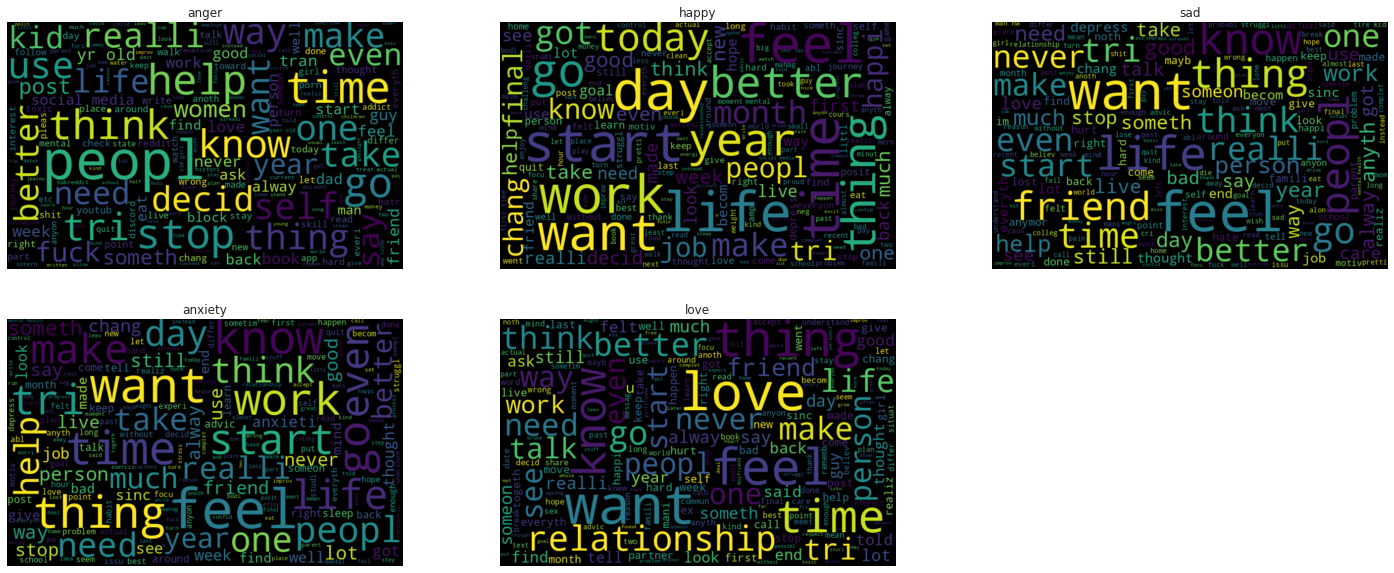

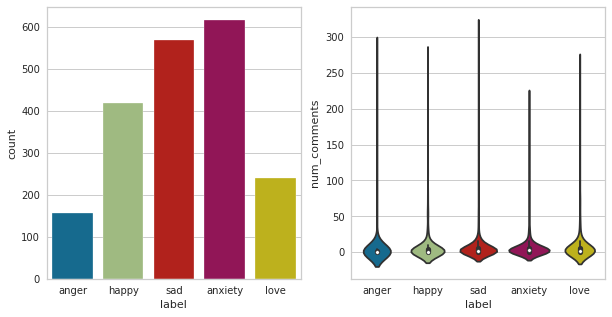

In [ ]:
analysis(posts)